## TP2 Groupe 12

- Châkirou ALABANI
- Caroline Fortier
- Mahsa Farnia

In [1]:
import sklearn
import numpy as np
import scipy as sp
import pandas as pd
%matplotlib notebook
%matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns

## 1.  Analyse des données


In [2]:
#import des données 
file_a = "données/order_products__prior_specials.csv"
file_b = "données/orders_distance_stores_softmax.csv"

# creation des dataframes
data_a = pd.read_csv(file_a)
data_b = pd.read_csv(file_b)

print("Shape of order_products__prior_specials : ", data_a.shape )
print("Shape of orders_distance_stores_softmax : ", data_b.shape )

Shape of order_products__prior_specials :  (1172312, 6)
Shape of orders_distance_stores_softmax :  (136026, 10)


In [3]:
# affichage des features
#1 order_products__prior_specials
print("Features of order_products__prior_specials : ", list(data_a.columns))

#1 orders_distance_stores_softmax
print("Features of orders_distance_stores_softmax", list(data_b.columns))


Features of order_products__prior_specials :  ['Unnamed: 0', 'order_id', 'product_id', 'add_to_cart_order', 'reordered', 'special']
Features of orders_distance_stores_softmax ['Unnamed: 0', 'user_id', 'store_id', 'distance', 'order_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']


Nous disposons de 2 differents dataframe disposant d'attributs communs. 
Nous allons effectuer un melange des deux dataframes afin d'obtenir un seule dataframe sur la base de l'attribut "order_id" ( id de la commande).

In [4]:
# Melange des deux dataframe sur l'attribut "order_id"
data = pd.merge(data_a, data_b, on='order_id')

# save the merged data
data.to_csv("data.csv", index=False)

#removing count columns 
data.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'], inplace=True)

#Features and shape
print("Features of merged data", list(data.columns))
print("Shape of merged data : ", data.shape )


Features of merged data ['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'special', 'user_id', 'store_id', 'distance', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
Shape of merged data :  (1172312, 13)


In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) 
data.describe()

,order_id,product_id,add_to_cart_order,reordered,special,user_id,store_id,distance,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,1172312.000,1172312.000,1172312.000,1172312.000,1172312.000,1172312.000,1172312.000,1172312.000,1172312.000,1172312.000,1172312.000,1158441.000
mean,1710805.865,25583.171,7.311,0.774,9.746,101148.592,4.497,1.252,49.509,2.850,12.987,3.150
std,986504.940,14036.934,6.662,0.418,14.971,60529.756,2.858,0.657,29.064,1.920,4.249,2.730
min,15.000,1.000,1.000,0.000,0.000,210.000,0.000,0.003,1.000,0.000,0.000,0.000
25%,857192.000,13575.000,3.000,1.000,0.000,49186.000,2.000,0.764,24.000,1.000,10.000,1.000
50%,1713000.000,25146.000,5.000,1.000,0.000,99352.000,4.000,1.171,49.000,3.000,13.000,3.000
75%,2563004.000,38016.000,10.000,1.000,15.000,154556.000,7.000,1.655,75.000,5.000,16.000,4.000
max,3421069.000,49683.000,98.000,1.000,50.000,206105.000,9.000,4.844,99.000,6.000,23.000,30.000


Après mélange des deux dataframes, nous obtenons un nouveau dataframe de dimensions (1172312, 15)

## (a) Réduction des données a 5%

Les dimensions de nos données sont de (1172312, 15).

Nous disposons de 13 features, cela est raisonnable, donc il n'est pas nécessaire de faire une réduction de variables. Parcontre le nombre d'entrées est conséquent (1172312). Nous allons donc faire une reduction de dimensions à hauteur de 5% tout en préservant la representativité de chaque données afin de réduire le temps de calcul.

Afin de faire notre reduction de données, nous avons identifiés deux attributs catégorielles importantes pour le maintien des propriétés statiques : *special & distance*

In [6]:
# Affichage des differentes valeurs de "special" & "distance"
unique_special_categories = data['special'].unique()
unique_distance_categories = data['distance'].unique()

print("Different categories of 'special':")
print(unique_special_categories)

print("\nNumber of different categories of 'distance_category':")
print(len(unique_distance_categories))

Different categories of 'special':
[15  0 50 30]

Number of different categories of 'distance_category':
13736


L'attribut distance est une variable contiinue représentant la distance euclidienne entre différents magasins et l’utilisateur. Elle dispose 136736 valeurs différentes. Nous avons donc besoin de discrétiser cette variable continue.

In [7]:
max_distance = data['distance'].max()
min_distance = data['distance'].min()

print("Max distance:", max_distance)
print("Min distance:", min_distance)

Max distance: 4.843816632166652
Min distance: 0.0028630733884864


In [8]:
# Déterminer les intervalles pour la discrétisation
num_intervals = 3  # Nombre de catégories spécifiées ('Proche', 'Moyen', 'Loin')
interval_size = (max_distance - min_distance) / num_intervals

# Générer les points de coupure pour la discrétisation
cut_points = [min_distance + i * interval_size for i in range(num_intervals)]
cut_points.append(max_distance)  # Ajouter la valeur maximale comme dernier point de coupure

# Étiquettes pour les catégories discrétisées
labels = ['Proche', 'Moyen', 'Loin']

# Appliquer la discrétisation en utilisant pd.cut()
data['distance_category'] = pd.cut(data['distance'], bins=cut_points, labels=labels)

# Imprimer les intervalles pour chaque catégorie
print("Intervals for each category:")
for i, label in enumerate(labels):
    if i == 0:
        print(label, ":", "[{}, {})".format(min_distance, cut_points[i+1]))
    elif i == len(labels) - 1:
        print(label, ":", "[{}, {})".format(cut_points[i], max_distance))
    else:
        print(label, ":", "[{}, {})".format(cut_points[i], cut_points[i+1]))

# Afficher les premières lignes du DataFrame avec la nouvelle colonne 'distance_category'
print(data[['distance', 'distance_category']].head())


Intervals for each category:
Proche : [0.0028630733884864, 1.616514259647875)
Moyen : [1.616514259647875, 3.2301654459072635)
Loin : [3.2301654459072635, 4.843816632166652)
   distance distance_category
0     0.305            Proche
1     0.305            Proche
2     0.305            Proche
3     0.305            Proche
4     0.305            Proche


Nous avons obtenu trois intervalles :
- Proche : [0.0028630733884864, 1.616514259647875)
- Moyen : [1.616514259647875, 3.2301654459072635)
- Loin : [3.2301654459072635, 4.843816632166652)


Nous allons donc faire un échantillonage stratifié sur la base de ces deux attributs.

Note: L'échantillonnage stratifié est une technique d'échantillonnage dans laquelle la population est divisée en sous-groupes, connus sous le nom de strates, qui partagent des caractéristiques similaires.

In [9]:
# imports
from sklearn.model_selection import train_test_split

# Suppression des lignes contenant des valeurs NaN dans les colonnes 'special' et 'distance_category'
cleaned_data = data.dropna(subset=['special', 'distance_category'])

# Stratification basée sur les colonnes 'special' et 'distance_category'
data_train, sampled_data = train_test_split(cleaned_data, test_size=0.05, stratify=cleaned_data[['special', 'distance_category']], random_state=42)

print("Dimensions of sampled data : ", sampled_data.shape )

#save sampled data
sampled_data.to_csv("sampled_data.csv", index=False)

# Afficher les statistiques des strates dans l'échantillon
sample_strata_counts = sampled_data.groupby(['special', 'distance_category']).size()
print("Stratified Sampling Results:")
print(sample_strata_counts)



Dimensions of sampled data :  (58612, 14)
Stratified Sampling Results:
special  distance_category
0        Proche               27250
         Moyen                 9743
         Loin                   175
15       Proche                7208
         Moyen                 2590
         Loin                    50
30       Proche                5724
         Moyen                 2049
         Loin                    41
50       Proche                2776
         Moyen                  988
         Loin                    18
dtype: int64


Visualisons les statistiques de nos donnes avant et après l'échantillonnage

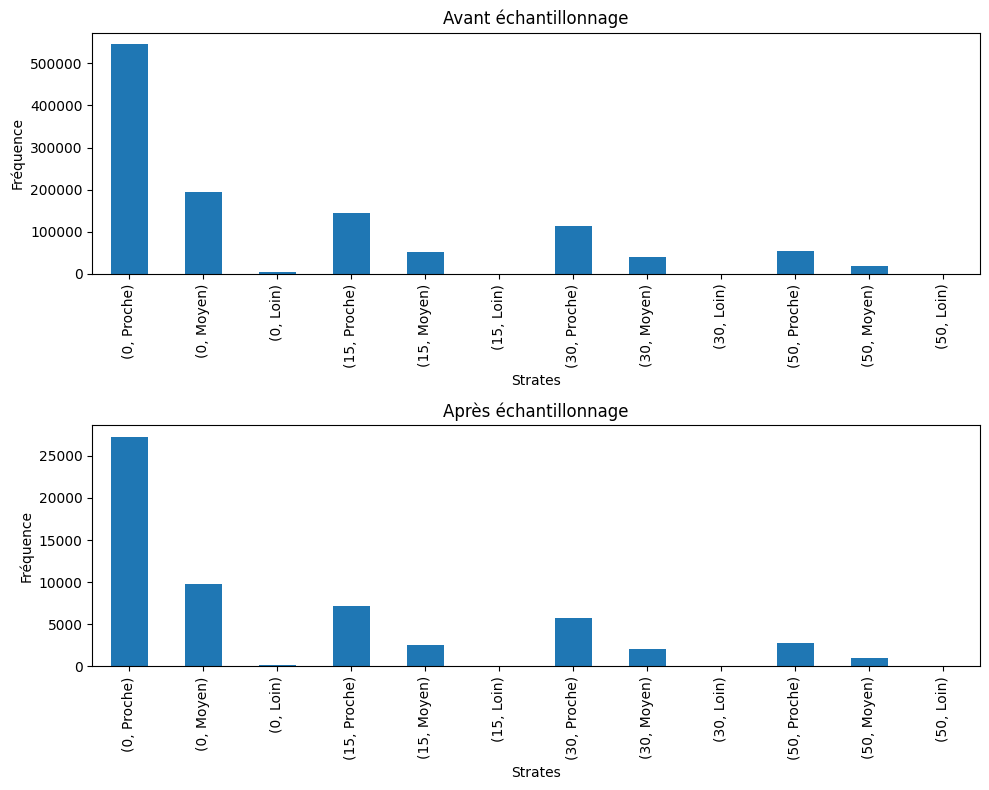

In [10]:
%matplotlib inline

# Calculer les statistiques des strates avant et après l'échantillonnage
original_strata_counts = data.groupby(['special', 'distance_category']).size()
sample_strata_counts = sampled_data.groupby(['special', 'distance_category']).size()

# Créer un subplot pour chaque ensemble de données
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot avant échantillonnage
original_strata_counts.plot(kind='bar', ax=axs[0])
axs[0].set_title('Avant échantillonnage')
axs[0].set_xlabel('Strates')
axs[0].set_ylabel('Fréquence')

# Plot après échantillonnage
sample_strata_counts.plot(kind='bar', ax=axs[1])
axs[1].set_title('Après échantillonnage')
axs[1].set_xlabel('Strates')
axs[1].set_ylabel('Fréquence')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher le graphique
plt.show()


Nous observons sur ces deux figures que la representativité des différentes strates de nos deux données reste la même.

Les dimensions de notre nouvelle dataframe est de (58612, 14)

## (a)(i) Visualisation de la distribution des données originales vs 5%

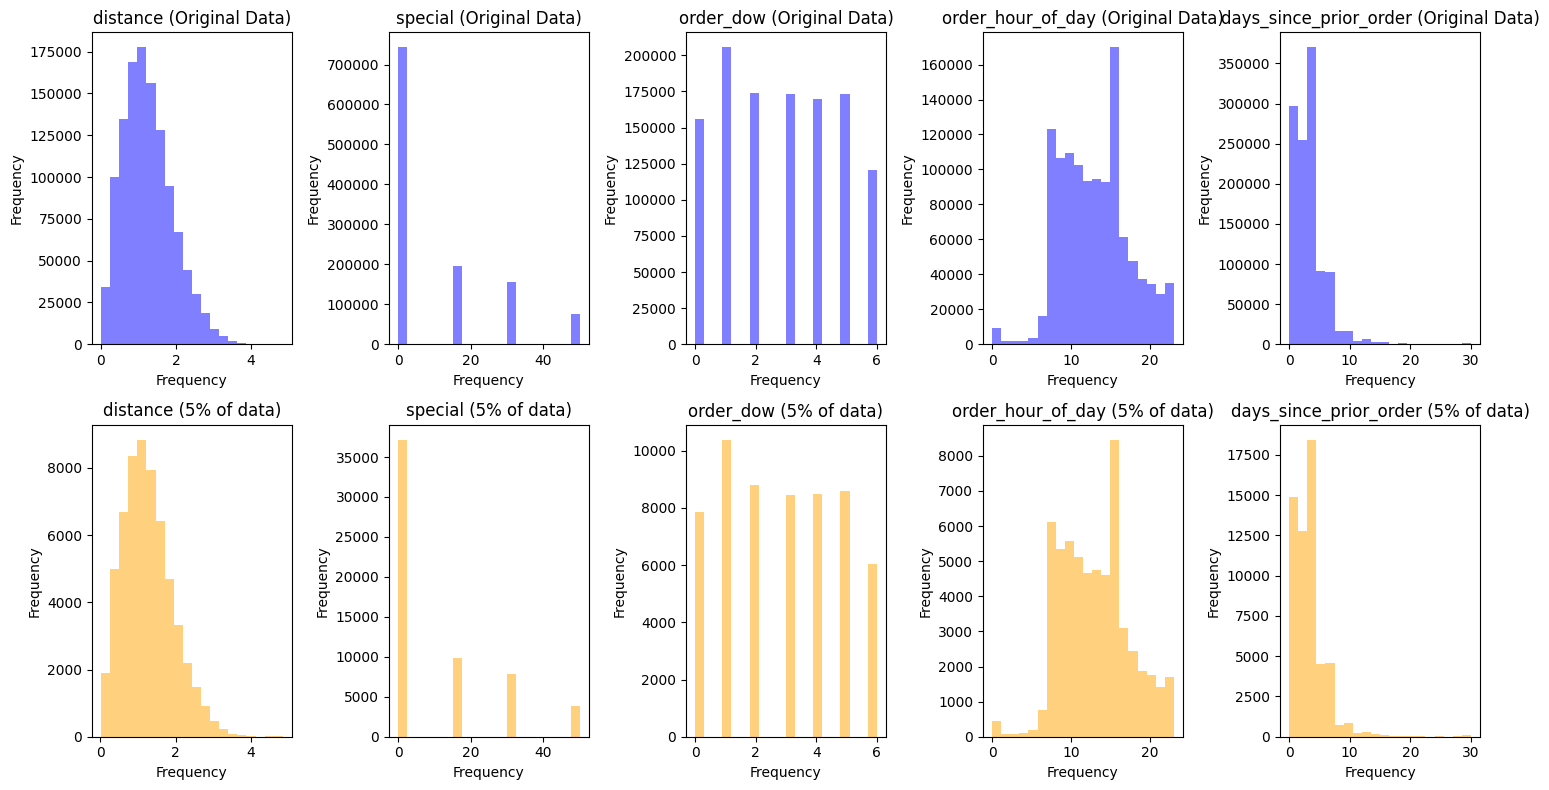

In [11]:
def plot_histograms_side_by_side(df1, df2):
    columns = ['distance', 'special', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
    fig = plt.figure(figsize=(15, 8))
 
    for i, column in enumerate(columns, 1):
        plt.subplot(2, 5, i)  # 2 rows, 5 columns, position i for df1
        plt.hist(df1[column], bins=20, color='blue', alpha=0.5)
        plt.title(f"{column} ({df1.name})")
        plt.ylabel('Frequency')
        if i <= 5:  # Only set x-axis label for the bottom row
            plt.xlabel('Frequency')
 
    for i, column in enumerate(columns, 6):
        plt.subplot(2, 5, i)  # 2 rows, 5 columns, position i for df2
        plt.hist(df2[column], bins=20, color='orange', alpha=0.5)
        plt.title(f"{column} ({df2.name})")
        plt.ylabel('Frequency')
        if i <= 10:  # Only set x-axis label for the bottom row
            plt.xlabel('Frequency')
    plt.tight_layout()
    plt.show()
 
data.name = 'Original Data'
sampled_data.name = f"5% of data"
plot_histograms_side_by_side(data, sampled_data)

## (b) Préparation des données

In [12]:
# Affichage des nombres, taux et types des valeurs manquantes par attribut
nb_m = sampled_data.isnull().sum().sort_values()[50:]
ratio_m = (sampled_data.isnull().sum()/sampled_data.shape[0]).sort_values()[50:]
manquant = pd.concat([nb_m, ratio_m], axis=1, sort=False)

# Afficher la liste des attributs avec le nombres de données manquantes
pd.DataFrame({'Types': sampled_data[list(manquant.index.values)].dtypes,
                       'Nb manquants': nb_m,
                      'Ratio manquants%': ratio_m,})

,Types,Nb manquants,Ratio manquants%


Nous ne disposons d'aucune données manquante dans notre dataframe

In [13]:
# Count NaN values for each attribute
nan_count = sampled_data.isnull().sum()

# Calculate the ratio of NaN values
nan_ratio = nan_count / sampled_data.shape[0]

# Concatenate NaN count and ratio into a DataFrame
nan_info = pd.concat([nan_count, nan_ratio], axis=1, keys=['Nb nans', 'Ratio manquants%'])

# Display attributes with NaN values
nan_info = nan_info[nan_info['Nb nans'] > 0]  # Filter attributes with NaN values
nan_info['Types'] = sampled_data[nan_info.index].dtypes  # Add data types of attributes
print(nan_info)


                        Nb nans  Ratio manquants%    Types
days_since_prior_order      700             0.012  float64


Nous avons plusieurs valeurs NaN pour l'attribut days_since_prior_order. (0.012%)

Nous allons remplacer tous ceux là par zeros car par hypothèse nous supposons que les valeurs NaN correspondent aux données des utilisateurs faisant des commandes pour la premiè fois.

## Division des données en deux groupes (train et test) pour des proportions de 80 et 20 respectivement tout en préservant la representativité

In [14]:
# Division des données en train et test 
train_data, test_data = train_test_split(sampled_data, test_size=0.2, stratify=sampled_data[['special', 'distance_category']], random_state=42)

# Affichage des statistiques des strates pour l'ensemble d'entraînement
train_strata_counts = train_data.groupby(['special', 'distance_category']).size()
print("Statistiques des strates pour l'ensemble d'entraînement :")
print(train_strata_counts)

# Affichage des statistiques des strates pour l'ensemble de test
test_strata_counts = test_data.groupby(['special', 'distance_category']).size()
print("\nStatistiques des strates pour l'ensemble de test :")
print(test_strata_counts)


Statistiques des strates pour l'ensemble d'entraînement :
special  distance_category
0        Proche               21800
         Moyen                 7794
         Loin                   140
15       Proche                5766
         Moyen                 2072
         Loin                    40
30       Proche                4579
         Moyen                 1639
         Loin                    33
50       Proche                2221
         Moyen                  790
         Loin                    15
dtype: int64

Statistiques des strates pour l'ensemble de test :
special  distance_category
0        Proche               5450
         Moyen                1949
         Loin                   35
15       Proche               1442
         Moyen                 518
         Loin                   10
30       Proche               1145
         Moyen                 410
         Loin                    8
50       Proche                555
         Moyen                 198
      

In [15]:
# removing non numeric data from train and test data
# Remove the columns 'eval_set' and 'distance_category' from train_data
train_data = train_data.drop(['eval_set', 'distance_category'], axis=1)

# Remove the columns 'eval_set' and 'distance_category' from test_data
test_data = test_data.drop(['eval_set', 'distance_category'], axis=1)


In [16]:
# Replace NaN values with zeros
train_data = train_data.fillna(0)
test_data = test_data.fillna(0)

## (c) Visualisation des données train et test

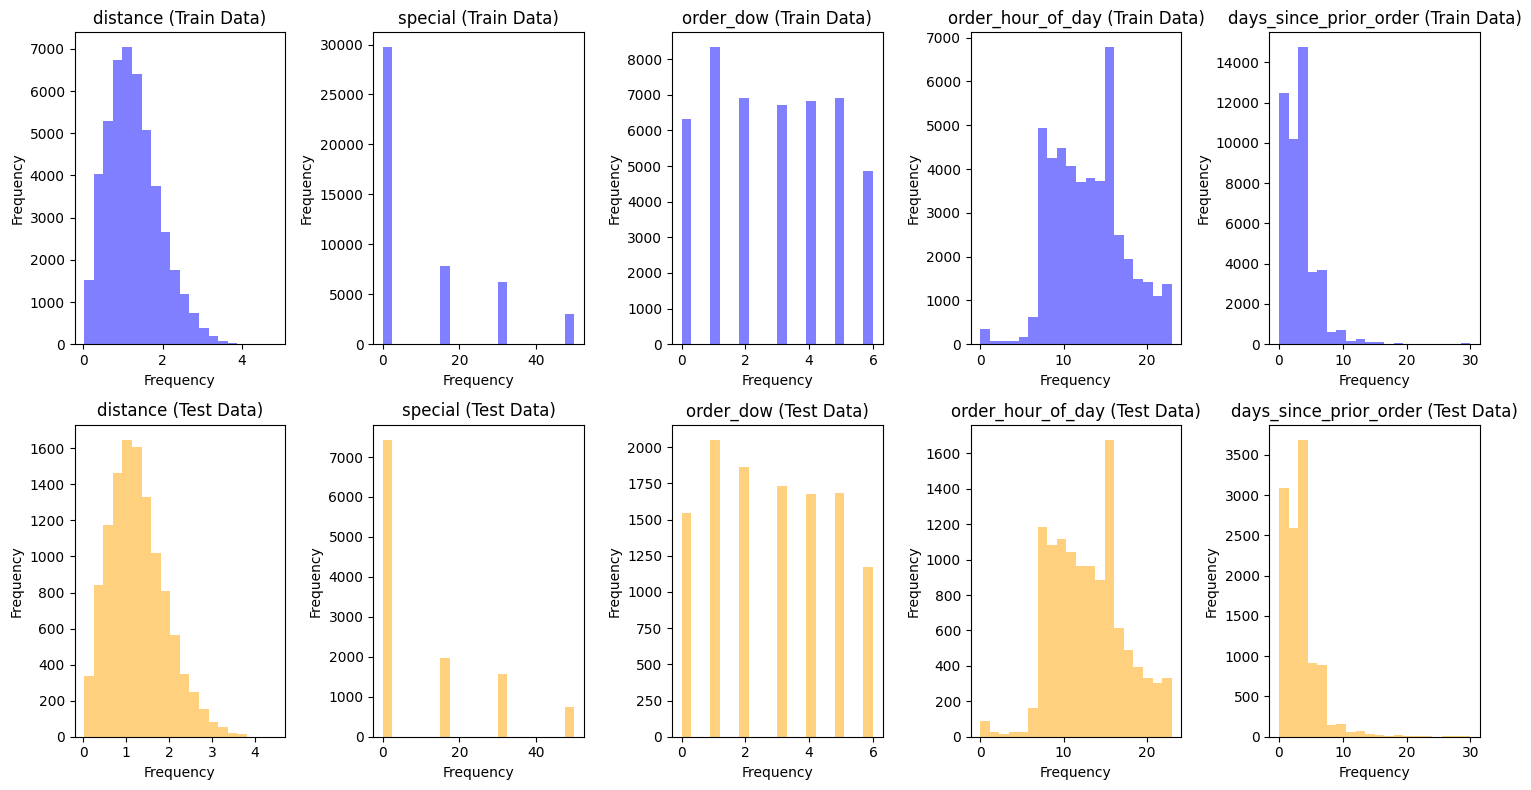

In [17]:
# Créer une figure
train_data.name = 'Train Data'
test_data.name = 'Test Data'
plot_histograms_side_by_side(train_data, test_data)


## Analyse des figures & interprétation

L'analyse de ces figures permet de voir la répartition des données d'entraînement et de test par rapport aux différentes valeurs des attributs 'distance', 'special', 'order_dow', 'order_hour_of_day', 'days_since_prior_order.

Les distributions sont similaires entre les données d'entraînement et de test pour chaque attribut, cela indique une bonne représentativité de l'ensemble de test par rapport à l'ensemble d'entraînement.


Les deux ensembles sont représentatifs l'un de l'autre en ce qui concerne la distribution des valeurs des différents attributs, Le modèle entraîné sur les données d'entraînement pourra généraliser efficacement sur de nouvelles données non vues lors de la phase de test.

# 2. Choix du modèle de prédiction 


## (a) Implémentation en python de modèles de prédiction

## CNN (réseau de neurones convolutifs) avec 2 couches internes cachées avec la fonction ReLU et finalement la couche de sortie avec deux neurones (0 et 1) utilisant la fonction soft max. 

Pour implémenter le modèle de prédiction utilisant un réseau de neurones convolutifs (CNN) avec 2 couches cachées internes et une couche de sortie avec deux neurones utilisant la fonction softmax, nous allons utiliser la bibliothèque TensorFlow en Python.

*imports*

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

2024-04-04 23:41:44.279444: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 23:41:44.340953: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 23:41:44.341725: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 23:41:45.854937: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


*Préparation des données*

In [19]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Séparation des attributs prédictifs et de la variable cible
X_train = train_data.drop(['reordered'], axis=1)
y_train = train_data['reordered']

X_test = test_data.drop(['reordered'], axis=1)
y_test = test_data['reordered']

# Transformation des données en tableaux numpy
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Conversion des labels en one-hot encoding
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)

# # Conversion des labels en format one-hot encoding
# onehot_encoder = OneHotEncoder(categories='auto', sparse_output=False)
# y_train_onehot = onehot_encoder.fit_transform(y_train_encoded.astype('float32').reshape(-1, 1))
# y_test_onehot = onehot_encoder.transform(y_test_encoded.astype('float32').reshape(-1, 1))

# valeur de input_shape
input_shape = X_train.shape[1:]


In [20]:
# creation d'un set de validation 
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

*Construction du modèle*


Nous allons créer un modèle séquentiel et y ajouter les couches convolutives nécessaires.

La 1ere couche possède 64 neurones et utilise la fonction d'activation ReLU. La forme de l'entrée est spécifiée comme étant input_shape, où input_dim représente le nombre de features.

La 2eme couche possède 32 neurones et utilise la fonction d'activation ReLU Cette couche n'a pas besoin de spécifier la forme de l'entrée car elle est déduite automatiquement de la couche précédente

La 3eme couche, couche de sortie comporte 2 neurones correspondant aux classes de sortie (0 et 1). La fonction d'activation softmax est utilisée pour produire une distribution de probabilités sur les classes de sortie.

*Compilation du modèle*

Définition des paramètres essentiels pour l'entraînement du modèle neuronal. La fonction de perte, l'optimiseur et les métriques sont des composants clés qui influencent la manière dont le modèle est entraîné et évalué. En utilisant la perte d'entropie croisée catégorique, l'optimiseur Adam et la métrique de précision, nous pouvons entraîner le modèle à classer avec précision les données d'entrée dans différentes classes.

In [21]:
from tensorflow.keras import layers, models

# Define the CNN model
def create_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))  # Input layer
 
    # Convolutional layers
    model.add(layers.Dense(64, activation='relu'))  # Fully connected layer with 64 units and ReLU activation

    model.add(layers.Dense(32, activation='relu'))
 
    # Output layer with softmax activation for binary classification
    model.add(layers.Dense(2, activation='softmax'))
 
    return model
 
# Assuming train_data_for_model is your training data
# Create the CNN model
model = create_cnn_model(X_train.shape[1])
 
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
 
# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 2914 (11.38 KB)
Trainable params: 2914 (11.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


*Entrainement du modèle*



In [22]:

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# # Make predictions
# predictions = model.predict(X_val)

Epoch 1/10
1466/1466 [==============================] - 5s 3ms/step - loss: 2544.1997 - accuracy: 0.6477 - val_loss: 4441.1504 - val_accuracy: 0.7747
Epoch 2/10
1466/1466 [==============================] - 4s 2ms/step - loss: 2059.3179 - accuracy: 0.6520 - val_loss: 3346.1462 - val_accuracy: 0.2765
Epoch 3/10
1466/1466 [==============================] - 3s 2ms/step - loss: 1568.2174 - accuracy: 0.6529 - val_loss: 189.5996 - val_accuracy: 0.2682
Epoch 4/10
1466/1466 [==============================] - 3s 2ms/step - loss: 1242.6101 - accuracy: 0.6530 - val_loss: 2534.7061 - val_accuracy: 0.2266
Epoch 5/10
1466/1466 [==============================] - 3s 2ms/step - loss: 1080.2186 - accuracy: 0.6566 - val_loss: 2299.5132 - val_accuracy: 0.2341
Epoch 6/10
1466/1466 [==============================] - 3s 2ms/step - loss: 749.3732 - accuracy: 0.6567 - val_loss: 292.0525 - val_accuracy: 0.7719
Epoch 7/10
1466/1466 [==============================] - 4s 2ms/step - loss: 719.4414 - accuracy: 0.6592

*Evaluation du model*

In [23]:
# # Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

# # Make predictions
# predictions = model.predict(X_val)

367/367 [==============================] - 1s 2ms/step - loss: 608.6482 - accuracy: 0.7756
Validation Loss: 608.648193359375, Validation Accuracy: 0.7755693793296814


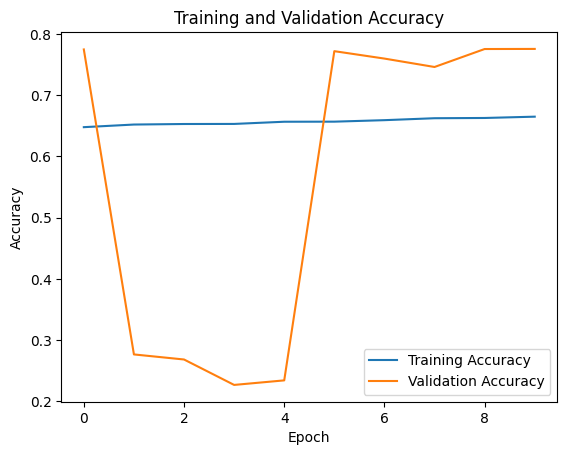

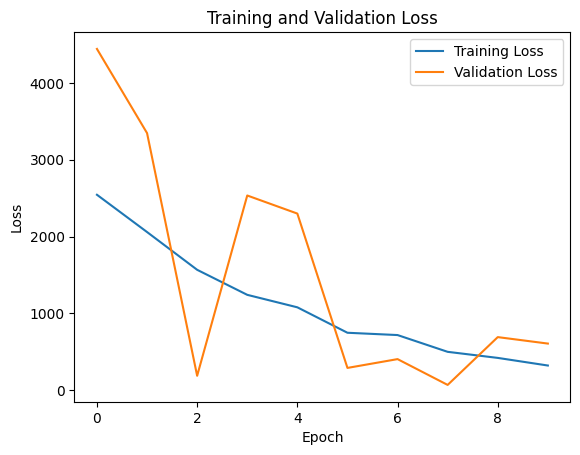

In [24]:

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [25]:
import numpy as np

# Check for NaN values in X_train
nan_indices = np.argwhere(np.isnan(X_train))

if len(nan_indices) > 0:
    print("NaN values found in X_train at indices:")
    print(len(nan_indices))
else:
    print("No NaN values found in X_train.")


No NaN values found in X_train.


## SVM (machines à vecteurs de support) en recherchant de l'hyperplan optimal

In [26]:
# from sklearn import svm
# # from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# #

# # data = sampled_data_0.drop('reordered', axis=1)
# # labels = sampled_data_0['reordered']

# # X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# model = svm.SVC(kernel='linear')  #rbf

# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)